# Transformer, many-to-many with text
### Decoder Only Architecture

Let's revisit text generation and see how we can use Attention to create a Transformer instead of an LSTM. The type of Transformer network we will be using is called a "Decoder only" as there is no cross-attention.
We will instead be using a type of Self-Attention called "Masked Self-Attention". Similar to regular Self-Attention, "Masked Self-Attention" uses "Causal Masking" to prevent tokens from querying other tokens that are later in the input sequence.<br>
Why?
<br>
As we're doing next-token prediction, if we let a token query every token in the sequence it will be able to simply "look" at what comes next in the sequence and return exactly what comes next! This is not useful as at test time when we want it to generate text it won't be able to do that!<br>
With "Causal Masking" we simply mask-out (multiply by zero) regions of the attention map that correspond to a token querying tokens that are later in the sequence. As a result a token will only be able to query itself, or any token that came BEFORE it in the sequence!

<img src="../data/llm_architecture_comparison.png" width="600" align="center">
<br>
We don't be exactly implementing the Decoder only Transformer detailed above, our network will basically be the Decoder from the Encoder-Decoder network without the Cross-Attention (input from the Encoder).
<br>
NOTE: We will cover Encoder-Decoder networks in the next notebook!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re
import math
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.distributions import Categorical

from torchtext.datasets import WikiText2, EnWik9, AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model

torch.backends.cuda.matmul.allow_tf32 = True
import ast
import sys

sys.path.append("../")

from recsys import config

2024-12-19 23:55:53.752 | INFO     | recsys.config:<module>:11 - PROJ_ROOT path is: /home/artem216/transformer-recsys


In [2]:
# Define the hyperparameters
# Learning rate for the optimizer
learning_rate = 1e-4

# Number of epochs for training
nepochs = 100

# Batch size for data loaders
batch_size = 256

# Maximum sequence length for text inputs
max_len = 24

# Root directory of the dataset
data_set_root = "../../datasets"



In [3]:
df_train = pd.read_csv(config.PROCESSED_DATA_DIR / "x_train_ids.csv")
df_test = pd.read_csv(config.PROCESSED_DATA_DIR / "x_test_ids.csv")


In [4]:
unique_articles_train = set()
unique_articles_test = set()

for articles in df_train["articles"]:
    if isinstance(articles, str):
        articles = ast.literal_eval(articles)
    unique_articles_train.update(articles)

for articles in df_test["articles"]:
    if isinstance(articles, str):
        articles = ast.literal_eval(articles)
    unique_articles_test.update(articles)

unique_articles = unique_articles_train.union(unique_articles_test) 

article_id_map = {article_id: idx for idx, article_id in enumerate(unique_articles, start=3)}

In [5]:
article_id_map[0] = 0
article_id_map[1] = 1
article_id_map[2] = 2
article_id_map

{559616001: 3,
 742912002: 4,
 742912003: 5,
 559616013: 6,
 559616014: 7,
 399061008: 8,
 559616017: 9,
 557994003: 10,
 724906006: 11,
 663679001: 12,
 399061028: 13,
 660308007: 14,
 572797001: 15,
 572797002: 16,
 767869001: 17,
 823165001: 18,
 767869002: 19,
 719655001: 20,
 816423004: 21,
 516903005: 22,
 589222001: 23,
 605094001: 24,
 589222005: 25,
 266875001: 26,
 695632001: 27,
 778064001: 28,
 695632002: 29,
 778064003: 30,
 778064005: 31,
 778064004: 32,
 436261001: 33,
 547365003: 34,
 713253003: 35,
 457466002: 36,
 794575001: 37,
 778064028: 38,
 777892001: 39,
 457892003: 40,
 853881001: 41,
 824185001: 42,
 695632041: 43,
 806605001: 44,
 660599001: 45,
 660599002: 46,
 708428002: 47,
 708428003: 48,
 660599013: 49,
 660599014: 50,
 660599016: 51,
 529953001: 52,
 529953007: 53,
 685814001: 54,
 660726001: 55,
 685814003: 56,
 685814005: 57,
 775328001: 58,
 685814033: 59,
 678687001: 60,
 762143001: 61,
 589599001: 62,
 779551002: 63,
 806388001: 64,
 806388002: 65,

In [32]:
import numpy as np

# Функция для генерации случайного вектора
def random_vector(dim):
    return np.random.rand(dim)

# Функция для ортогонализации векторов с помощью метода Грама-Шмидта
def gram_schmidt(vectors):
    orthogonal_vectors = []
    for v in vectors:
        for u in orthogonal_vectors:
            v -= np.dot(v, u) / np.dot(u, u) * u
        orthogonal_vectors.append(v / np.linalg.norm(v))  # Нормализация
    return np.array(orthogonal_vectors)

# Генерация трех случайных векторов
dim = 768
random_vectors = [random_vector(dim) for _ in range(3)]

# Ортогонализация
orthogonal_vectors = gram_schmidt(random_vectors)

In [34]:
orthogonal_vectors[0]

array([2.18538506e-02, 4.87433831e-02, 2.90439126e-02, 4.47840595e-02,
       2.37189882e-02, 3.65756140e-02, 2.16320260e-02, 5.50472375e-02,
       1.62075268e-02, 5.60131930e-02, 8.25226566e-03, 4.58911652e-02,
       4.12936651e-03, 2.31082323e-02, 1.08869443e-02, 5.39152967e-02,
       4.80895425e-02, 1.87589846e-02, 3.83508207e-02, 5.32458071e-02,
       8.55478359e-03, 6.11773556e-02, 1.65917477e-02, 2.71972811e-02,
       5.37231046e-02, 2.59030122e-02, 4.78639954e-02, 1.86850047e-02,
       5.07286063e-02, 3.72573162e-02, 3.56996644e-02, 3.03554431e-02,
       4.23767666e-02, 7.75655721e-03, 1.70323945e-02, 4.96802705e-02,
       4.39720079e-02, 6.20284914e-02, 1.57342494e-02, 1.36970421e-03,
       4.86349196e-02, 8.59973933e-03, 1.16858598e-02, 5.57276993e-02,
       6.11784495e-02, 4.56479177e-02, 3.76668766e-02, 5.65566981e-02,
       4.71748362e-02, 7.90283660e-03, 5.43483193e-03, 3.42802348e-02,
       2.01646345e-02, 4.42593130e-02, 4.47822999e-02, 1.93267769e-02,
      

In [6]:
article_id_map[559616001]

3

In [7]:
embedings_df = pd.read_pickle(config.PROCESSED_DATA_DIR / "articles_embedings.pkl")

In [8]:
embedings_df["article_id"]

In [9]:
embedings_df["article_id"] = embedings_df["article_id"].map(article_id_map)

In [35]:
embedings_df[embedings_df["article_id"] == 0]["Embed_comb_text"][1000] = orthogonal_vectors[0]

/tmp/ipykernel_216694/455453172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedings_df[embedings_df["article_id"] == 0]["Embed_comb_text"][1000] = orthogonal_vectors[0]


In [40]:
embedings_df.loc[1000, "Embed_comb_text"] = orthogonal_vectors[0]

ValueError: Must have equal len keys and value when setting with an iterable

## Data processing and Tokenization

In [37]:
embedings_df[embedings_df["article_id"] == 0]["Embed_comb_text"][1000] == orthogonal_vectors[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [11]:
# import ast
# import torch
# from torch.utils.data import Dataset

# class CustomerDataset(Dataset):
#     def __init__(self, df, max_len, embed):
#         self.df = df
#         self.max_len = max_len
#         self.embed = embed

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         articles = self.df.iloc[idx]["articles"]
#         if isinstance(articles, str):
#             articles = ast.literal_eval(articles)
        
#         # Получаем векторы эмбеддингов для статей
#         article_embeddings = [
#             self.embed[self.embed["article_id"] == str(article)]["Embed_comb_text"].values[0] for article in articles
#         ]
        
#         # Преобразуем векторы в тензоры с типом long
#         article_tensors = [torch.tensor(embedding, dtype=torch.long) for embedding in article_embeddings]
        
#         # Паддинг и обрезка
#         if len(article_tensors) < self.max_len:
#             padding_length = self.max_len - len(article_tensors)
#             padding_tensor = torch.zeros((padding_length, article_tensors[0].size(0)), dtype=torch.long)
#             article_tensors = torch.cat((torch.stack(article_tensors), padding_tensor), dim=0)
#         else:
#             article_tensors = torch.stack(article_tensors)[:self.max_len]
        
#         # Создаем input_seq и target_seq
#         input_seq = torch.cat((torch.ones((1, article_tensors.size(1)), dtype=torch.long), article_tensors[:-1]), dim=0)  # <sos> - 1
#         target_seq = torch.cat((article_tensors[1:], torch.full((1, article_tensors.size(1)), 2, dtype=torch.long)))  # <eos> - 2
        
#         return input_seq, target_seq


In [12]:
class CustomerDataset(Dataset):
    def __init__(self, df, max_len, article_id_map):
        self.df = df
        self.max_len = max_len
        self.article_id_map = article_id_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        articles = self.df.iloc[idx]["articles"]
        if isinstance(articles, str):
            articles = ast.literal_eval(
                articles
            )
        articles = [
            self.article_id_map[article] for article in articles
        ]
        # <sos> - 1
        # <eos> - 2
        # <pad> - 0
        articles = [1]  + articles + [2] + [0] * (self.max_len - len(articles))  # Padding
        input_seq = torch.tensor(articles[:-1], dtype=torch.long)
        target_seq = torch.tensor(articles[1:], dtype=torch.long) # 1:
        return input_seq, target_seq

In [13]:
# Create training and testing datasets
df_train = pd.read_csv(config.PROCESSED_DATA_DIR / "x_train_ids.csv")
df_test = pd.read_csv(config.PROCESSED_DATA_DIR / "x_test_ids.csv")
# Create data loaders for the training and testing datasets
dataset_train = CustomerDataset(df_train, max_len, article_id_map)
dataset_test = CustomerDataset(df_test, max_len, article_id_map)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=8)



In [14]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not a special token
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [15]:
# train_tranform = T.Sequential(
#     # Tokeniz with pre-existing Tokenizer
#     T.SentencePieceTokenizer("spm_ag_news.model"),
#     ## converts the sentences to indices based on given vocabulary
#     T.VocabTransform(vocab=vocab),
#     ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
#     # 1 as seen in previous section
#     T.AddToken(1, begin=True),
#     # Crop the sentance if it is longer than the max length
#     T.Truncate(max_seq_len=max_len),
#     ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
#     # 2 as seen in previous section
#     T.AddToken(2, begin=False),
#     # Convert the list of lists to a tensor, this will also
#     # Pad a sentence with the <pad> token if it is shorter than the max length
#     # This ensures all sentences are the same length!
#     T.ToTensor(padding_value=0),
# )

# gen_tranform = T.Sequential(
#     # Tokeniz with pre-existing Tokenizer
#     T.SentencePieceTokenizer("spm_ag_news.model"),
#     ## converts the sentences to indices based on given vocabulary
#     T.VocabTransform(vocab=vocab),
#     ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
#     # 1 as seen in previous section
#     T.AddToken(1, begin=True),
#     # Convert the list of lists to a tensor, this will also
#     # Pad a sentence with the <pad> token if it is shorter than the max length
#     # This ensures all sentences are the same length!
#     T.ToTensor(padding_value=0)
# )


In [16]:
text = next(iter(data_loader_train))
# index = 0
# input_tokens = train_tranform(list(text))
# print("SENTENCE")
# print(text[index])
# print()
# print("TOKENS")
# print(vocab.lookup_tokens(input_tokens[index].numpy()))

In [17]:
text[0]

tensor([[  1, 655, 477,  ...,   0,   0,   0],
        [  1, 486,  33,  ...,   0,   0,   0],
        [  1, 497, 288,  ...,   0,   0,   0],
        ...,
        [  1, 326, 687,  ...,   0,   0,   0],
        [  1, 166, 166,  ...,   0,   0,   0],
        [  1, 939, 403,  ...,   0,   0,   0]])

In [18]:
# print("TOKENS BACK TO SENTENCE")

# pred_text = "".join(vocab.lookup_tokens(input_tokens[index].numpy()))
# pred_text.replace("▁", " ")

## Create Model

In [19]:
# Sinusoidal positional embeddings
class SinusoidalPosEmb(nn.Module):
    """
    Sinusoidal positional embeddings module.
    """

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        # Calculate sinusoidal positional embeddings
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

    
# Transformer block with Attention and causal masking
class TransformerBlock(nn.Module):
    """
    Transformer block with self-attention and causal masking.
    """

    def __init__(self, hidden_size=128, num_heads=4):
        super(TransformerBlock, self).__init__()

        # Layer normalization for input
        self.norm1 = nn.LayerNorm(hidden_size)

        # Multi-head self-attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size, 
                                                    num_heads=num_heads, 
                                                    batch_first=True,
                                                    dropout=0.1)

        # Layer normalization for attention output
        self.norm2 = nn.LayerNorm(hidden_size)

        # Feedforward neural network
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )

    def forward(self, x, padding_mask):
        # Create causal mask for Attention
        bs, l, h = x.shape
        mask = torch.triu(torch.ones(l, l, device=x.device), 1).bool()

        # Layer normalization
        norm_x = self.norm1(x)

        # Apply multi-head Attention
        x = self.multihead_attn(norm_x, norm_x, norm_x, attn_mask=mask, key_padding_mask=padding_mask)[0] + x

        # Layer normalization
        norm_x = self.norm2(x)

        # Apply feedforward neural network
        x = self.mlp(norm_x) + x
        return x

    
# "Decoder-Only" Style Transformer with Attention
class Transformer(nn.Module):
    """
    "Decoder-Only" Style Transformer with self-attention.
    """

    def __init__(self, num_emb, hidden_size=768, num_layers=3, num_heads=4):
        super(Transformer, self).__init__()

        # Token embeddings
        self.embeddings_tensor = torch.tensor(embedings_df["Embed_comb_text"].values.tolist(), device='cuda')
        # Positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)

        # List of Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

        # Output layer
        self.fc_out = nn.Linear(hidden_size, num_emb)

    def forward(self, input_seq):
        # reshape
        # reshaped_tensor = input_seq.view(32, -1)

        # Mask for padding tokens
        input_key_mask = input_seq == 0

        h = 768 
        bs, l = input_seq.shape
    
        output_tensor = self.embeddings_tensor[input_seq]

        # Add positional embeddings to token embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = output_tensor + pos_emb

        # Pass through Transformer blocks
        for block in self.blocks:
            embs = block(embs, padding_mask=input_key_mask)

        # Output predictions
        return self.fc_out(embs)


## Initialise Model and Optimizer

In [20]:
# Check if GPU is available, set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Embedding Size
hidden_size = 768

# Number of transformer blocks
num_layers = 8

# MultiheadAttention Heads
num_heads = 8

num_embeding = 1003
# Create model
tf_generator = Transformer(num_emb=num_embeding, num_layers=num_layers, 
                           hidden_size=hidden_size, num_heads=num_heads).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(tf_generator.parameters(), lr=learning_rate)

# Scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

# Custom transform that will randomly replace a token with <pad>
td = TokenDrop(prob=0.2)

# Initialize training loss logger and entropy logger
training_loss_logger = []
entropy_logger = []

/tmp/ipykernel_216694/3037266107.py:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  self.embeddings_tensor = torch.tensor(embedings_df["Embed_comb_text"].values.tolist(), device='cuda')


In [21]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in tf_generator.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 57474283 (Approximately 57 Million) Parameters!


## Training

In [22]:
device

device(type='cuda')

In [23]:
for epoch in trange(0, nepochs, leave=False, desc="Epoch"):    
    tf_generator.train()
    steps = 0
    for index, text in enumerate(tqdm(data_loader_train)):
        # Convert text to tokenized input

        input_text, output_text = text
        input_text = input_text.to(device)
        output_text = output_text.to(device)
        # Generate predictions
        with torch.cuda.amp.autocast():
            pred = tf_generator(input_text)
        # print(pred.shape)

        # Calculate loss with masked cross-entropy
        mask = (output_text != 0).float()
        loss = (loss_fn(pred.transpose(1, 2), output_text) * mask).sum()/mask.sum()
        
        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if index % 20 == 0:
            print("train_loss", loss, end="\r")
        # Log training loss and entropy
        training_loss_logger.append(loss.item())
        with torch.no_grad():
            dist = Categorical(logits=pred)
            entropy_logger.append(dist.entropy().mean().item())

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.Size([32, 32, 768, 256])

In [20]:
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Модель сохранена в {file_path}")

# Укажите путь, по которому хотите сохранить модель
file_path = config.MODELS_DIR / 'model_100_epoch.pth'
save_model(tf_generator, file_path)

Модель сохранена в /home/artem216/transformer-recsys/models/model_100_epoch.pth


## Plot Metrics

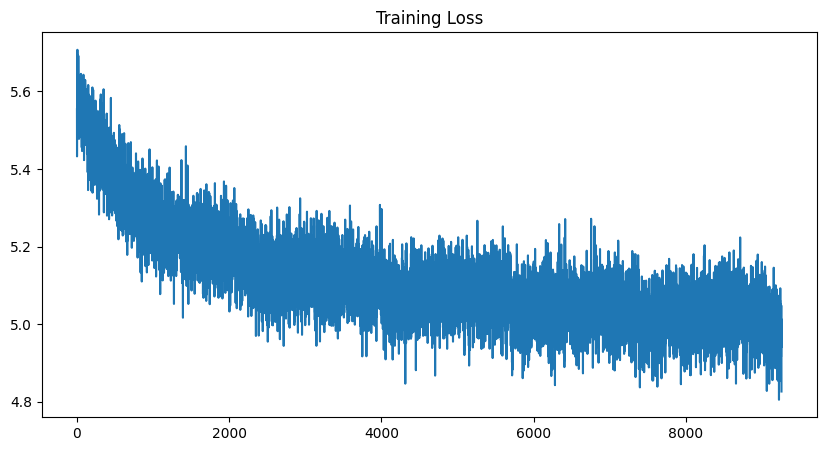

In [24]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger[1000:])
_ = plt.title("Training Loss")

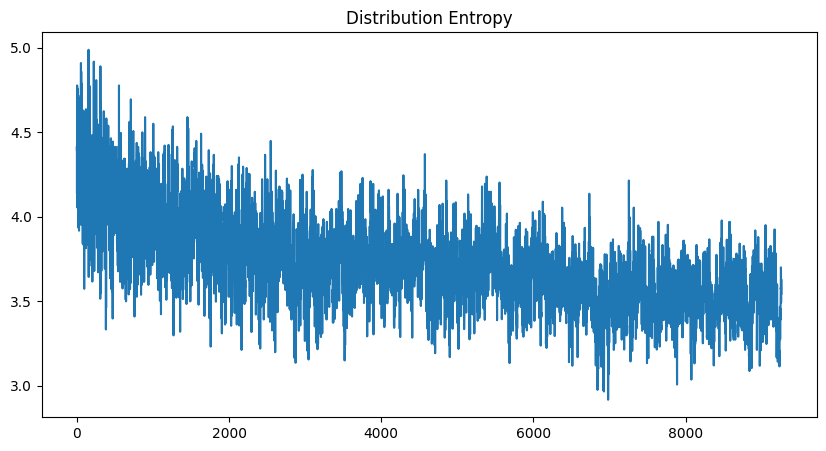

In [26]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(entropy_logger[1000:])
_ = plt.title("Distribution Entropy")

## Testing

In [18]:
# Get an example from the test set
text = next(iter(data_loader_test))

In [19]:
text

[tensor([[354, 274, 354,  ...,   0,   0,   0],
         [777, 528, 294,  ...,   0,   0,   0],
         [657, 654, 653,  ...,   0,   0,   0],
         ...,
         [111, 111,   0,  ...,   0,   0,   0],
         [423, 921, 784,  ...,   0,   0,   0],
         [693, 455, 302,  ...,   0,   0,   0]]),
 tensor([[274, 354,   0,  ...,   0,   0,   0],
         [528, 294, 185,  ...,   0,   0,   0],
         [654, 653, 652,  ...,   0,   0,   0],
         ...,
         [111,   0,   0,  ...,   0,   0,   0],
         [921, 784, 832,  ...,   0,   0,   0],
         [455, 302, 820,  ...,   0,   0,   0]])]

In [26]:
temp = 0.6


prompt = text[0]
prompt.cpu().numpy()

array([[354, 274, 354, ...,   0,   0,   0],
       [777, 528, 294, ...,   0,   0,   0],
       [657, 654, 653, ...,   0,   0,   0],
       ...,
       [111, 111,   0, ...,   0,   0,   0],
       [423, 921, 784, ...,   0,   0,   0],
       [693, 455, 302, ...,   0,   0,   0]])

In [ ]:
# # Set index of the example to use
# index = 0

# # Set temperature for sampling
# temp = 0.6

# # Split text into title and content
# title = text[index].split(":")[0]
# init_prompt = [title + ":"]  # Create initial prompt using the title

# # Extract content from text
# content = text[index].split(":")[1]

# # Tokenize the initial prompt
# init_tokens = gen_tranform(init_prompt)

# # Print initial prompt, original content, and tokenized prompt
# print("INITIAL PROMPT:")
# print(title)
# print("")
# print("ORIGINAL CONTENT:")
# print(content)
# print("")
# print("PROMPT TOKENS:")
# print(init_tokens)
# print(vocab.lookup_tokens(init_tokens[0].cpu().numpy()))

In [28]:
# List to log generated tokens
log_tokens = [prompt]

# Set the generator model to evaluation mode
tf_generator.eval()

# Generate tokens
with torch.no_grad():    
    for i in range(10):
        # Concatenate tokens from previous iterations
        input_tokens = torch.cat(log_tokens, 1)
        
        # Get model predictions for the next token
        data_pred = tf_generator(input_tokens.to(device))
        print(data_pred) 
        # Sample the next token from the distribution of probabilities
        # dist = Categorical(logits=data_pred[:, -1] / temp)
        # next_tokens = dist.sample().reshape(1, 1)
        
        # # Append the sampled token to the list of generated tokens
        # log_tokens.append(next_tokens.cpu())
        
        # # Check for end-of-sequence token and stop generation
        # if next_tokens.item() == 2:
        #     break

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]

In [ ]:
# Concatenate generated tokens into a single string
pred_text = "".join(vocab.lookup_tokens(torch.cat(log_tokens, 1)[0].numpy()))

# Print the generated text
print(pred_text)

In [ ]:
# Replace special tokens and characters in the generated text
pred_text_cleaned = pred_text.replace("▁", " ").replace("<unk>", "").replace("<sos>", "").replace("<eos>", "")

# Print the cleaned generated text
print(pred_text_cleaned)

In [ ]:
# Plot the softmax probabilities of the next token
_ = plt.plot(F.softmax(data_pred[0, -1] / temp, -1).cpu().numpy().flatten())